<a href="https://colab.research.google.com/github/SidhantMathur23/Joint-Sentence-Classification-in-Medical-Paper-Abstracts/blob/main/Neural_Network_for_Joint_Sentence_Classification_in_Medical_Paper_Abstracts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Introduction 

In this project, I will be replicating the deep learning models behind a research paper titled "PubMed 200k RCT: a Dataset for Sequenctial Sentence Classification in Medical Abstracts". The paper was released in 2017 and can be accessed from here : https://arxiv.org/abs/1710.06071

When it was released, the paper presented a new dataset called PubMed 200k RCT which consists of  nearly 200,000 labelled Randomized Controlled Trial (RCT) abstracts.

The goal of the dataset was to explore the ability for NLP models to classify sentences which appear in sequential order.
In simpler words, I am trying to create a neural network using NLP and tensorflow which can uncover the role of each sentence in the Randomized Controlled Trial (RCT) abstract, allowing researchers to skim through the literature and dive deeper when necessary.

In [ ]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sn 
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder 
from sklearn.metrics import accuracy_score,precision_recall_fscore_support,classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import tensorflow_hub as hub
import os
import random

# Confirm access to a GPU

Since I'm going to be building deep learning models, let's make sure we have a GPU. In Google Colab, you can set this up by going to Runtime -> Change runtime type -> Hardware accelerator -> GPU.

In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



# Get Data 

Before we can start building the models, we have to download the PubMed 200K RCT dataset. The authors of the paper have made the data they used for their research available publically and for free in the form of .txt files on GitHub. We can copy them to our local directory using git clone https://github.com/Franck-Dernoncourt/pubmed-rct.

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 0), reused 0 (delta 0), pack-reused 30
Unpacking objects: 100% (33/33), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


To begin with, the dataset we're going to be focused on is PubMed_20k_RCT_numbers_replaced_with_at_sign.

Rather than working with the whole 200k dataset, I"m keep our experiments quick by starting with a smaller subset.

Let's check the file contents.

In [ ]:
# Check what files are in the PubMed_20K dataset 
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


So, the PubMed_20K dataset file contains 3 files, train.txt, test.txt and dev.txt. So, for the sake of accessibility, let's store the path address of the file into a variable. I will access the train,test and dev datasets using that variable. 

In [ ]:
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

Storing the filenames of each of the datasets in a list

In [ ]:
# Check all of the filenames in the target directory
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

# Data Preprocessing 

Since our data is in the form of text, therefore, I will write a function to read each line of the data in a target file 

In [ ]:
# Create funciton to read all the lines of a document 
def get_lines(filename):
  """
  Reads filename (a text filename) and returns the lines of the text as a list.

  Args:
  filename: a string containing the target filepath 

  Returns:
  A list of strings with one string per line from the target filename
  """
  with open(filename,"r") as f:
    return f.readlines()

In [ ]:
# Let's read in the training lines from the training file
train_lines = get_lines(data_dir+"/train.txt")
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

## Formatting our data into the desired format 

Creating a function to convert each of our datasets into the following format: 

```
[{
    "line_number":0,
  'target': 'BACKGROUND',
  'text': 'Emotional eating is associated with overeating and the development of obesity .'
  'total_lines':11,
  ...
}]
```


In [ ]:
def preprocessing_text_with_line_numbers(filename):
  """
  Accepts the filename i.e is the file path of the file. The function will read the input lines from the file
  using the get_lines() function created earlier, extract information like "target","text" ect. 

  Returns:
  A list of dictionaries which contains details about each abstract, i.e a sentence, label for number of lines,
  label for total lines and target. 
  """
  input_lines = get_lines(filename)
  abstract_lines = "" # create an empty abstract 
  abstract_samples = []  # create a list to store the abstracts in the above format. Multiple dictionaries will be stored in this list.

  # Looping through each line in the target file 
  for line in input_lines:
    if line.startswith("###"):  # check to see if the line is an ID
      abstract_lines =""   # reset abstract string
      abstract_id = line
    elif line.isspace():  # if line begins with a "\n"
      abstract_split_lines = abstract_lines.splitlines()  # split the lines into different lines from where "\n" occurs 
      
      # iterate through each line and count them at the same time 
      for abstract_line_number,abstract_line in enumerate(abstract_split_lines):
        line_data = {} # create dictionary to store line data 
        target_text_split = abstract_line.split("\t")
        line_data["target"] = target_text_split[0]   # target of abstract
        line_data["text"] = target_text_split[1].lower()  # test of abstract
        line_data["line_number"] = abstract_line_number # what line number is the abstract
        line_data["total_lines"] = len(abstract_split_lines)-1 
        abstract_samples.append(line_data)  # adding the dictionary to the list 

    else:
      abstract_lines+= line  # if the above conditions aren't fulfilled, the line contains a labelled sentence
  
  return abstract_samples 

In [ ]:
# Get data from the files and preprocess it 
train_samples = preprocessing_text_with_line_numbers(data_dir+"/train.txt")
test_samples = preprocessing_text_with_line_numbers(data_dir+"/test.txt")
val_samples = preprocessing_text_with_line_numbers(data_dir+"/dev.txt")

Now that our data is in the desired form, we can start by converting it into a dataframe to visualize it and uncover the distribution of the data tags. We can use pandas for the conversion, the dictionary keys will be the column names. 

In [ ]:
train_df = pd.DataFrame(train_samples)
test_df = pd.DataFrame(test_samples)
val_df = pd.DataFrame(val_samples)
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [ ]:
# creating a function to visualize some important features of the dataset such as number of target variables and distribution of total lines 
def visualize(DataFrame):
  fig,(ax0,ax1) = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
  # Number of target labels in the training data 
  DataFrame.target.value_counts().plot.bar(ax=ax0);
  # Distribution of total_lines in the training data 
  DataFrame.total_lines.plot.hist(ax=ax1);

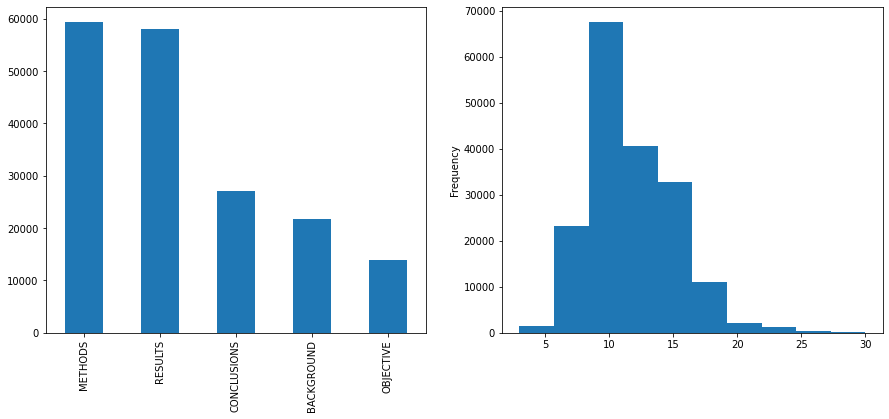

In [ ]:
visualize(train_df)

From the above figures, it looks like "METHOD" label occurs maximum number of times in the abstracts. And the length of most abstracts falls between 7 to 16 or so sentences. 

## Get list of sentences

 When we build our deep learning model, one of its main inputs will be a list of strings (the lines of an abstract). We can get these easily from our DataFrames by calling the `tolist()` method on our `text` columns.

In [ ]:
# Convert abstract text lines into list using tolist() method 
train_sentences = train_df.text.tolist()
val_sentences = val_df.text.tolist()
test_sentences = test_df.text.tolist()

train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Making numeric Labels

I'm going to create one hot and label encoded labels. We could get away with just making label encoded labels, however, TensorFlow's CategoricalCrossentropy loss function likes to have one hot encoded labels (this will enable us to use label smoothing later on).

To numerically encode labels we'll use Scikit-Learn's `OneHotEncoder` and `LabelEncoder` classes.

In [ ]:
# create one hot 
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1,1))

train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [ ]:
# create label encoder instance
label_encoder = LabelEncoder()
train_labels_label_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_label_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_label_encoded = label_encoder.transform(test_df["target"].to_numpy())

train_labels_label_encoded

array([3, 2, 2, ..., 4, 1, 1])

Now that we have an instance of label encoder, we can get the class names and the encoding associated with each class 

In [ ]:
# Get class encoding
num_classes = len(label_encoder.classes_) 
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

# Creating a series of experimental models 

We've proprocessed our data so now, in true machine learning fashion, it's time to setup a series of modelling experiments.

We'll start by creating a simple baseline model to obtain a score we'll try to beat by building more and more complex models as we move towards more complicated models.

For each model, we'll train it on the training data and evaluate it on the validation data.

Before we start creating these model, let's create a scoring function.



## Creating a scoring function

Creating a scoring funciton to evaluate the fit of our model on the training and validaiton datasets. 


To evaluate our baseline's predictions, we'll create a `calculate_results()` to compare them to the ground truth labels.

More specificially the `calculate_results()` function will help us obtain the following:
* Accuracy
* Precision
* Recall
* F1-score

In [ ]:
# create evaluation function 
def calculate_results(y_true,y_pred):
  model_accuracy = accuracy_score(y_true,y_pred)
  model_precision,model_recall,model_f1,_ = precision_recall_fscore_support(y_true,y_pred,average="weighted")
  model_results={
      "accuracy": model_accuracy,
      "precision":model_precision,
      "recall":model_recall,
      "f1": model_f1
  }
  return model_results

## Model 0: Getting a baseline model

Our first model we'll be a `TF-IDF Multinomial Naive Bayes` as recommended by Scikit-Learn's machine learning map.

To build it, we'll create a Scikit-Learn Pipeline which uses the `TfidfVectorizer` class to convert our abstract sentences to numbers using the `TF-IDF` (term frequency-inverse document frequecy) algorithm and then learns to classify our sentences using the `MultinomialNB` algorithm.

In [ ]:
# creating a pipeline 
model_0 = Pipeline([
  ("tf-idf",TfidfVectorizer()),
  ("clf",MultinomialNB())
])

# Fit the pipeline to the training data 
model_0.fit(X=train_sentences,y=train_labels_label_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
# scoring the model 
model_0.score(val_sentences,val_labels_label_encoded)

0.7218323844829869

It seems that our baseline model was able to bag 72.1% of the abstracts accurately!
This, along with the classification metrics, is going to be the baseline score for our upcoming models to beat

In [ ]:
# making prediciton based on tf-idf model 
baseline_pred = model_0.predict(val_sentences)
baseline_pred

array([4, 1, 3, ..., 4, 4, 1])

In [ ]:
# calculating results 
model_0_results = calculate_results(y_true=val_labels_label_encoded,y_pred=baseline_pred)
model_0_results

{'accuracy': 0.7218323844829869,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

## Preparing our data for deep models 



Now we have a baseline model to try and imporve upon. Let's try building deeper models to obtain more accurate results. For that, we will have to create vectorization and embedding layers. 

The vectorization layer will convert our text to numbers and the embedding layer will capture the relation ship between those numbers. 


Since we'll be turning our sentences into numbers, it's a good idea to figure out how many words are in each sentence.

When our model goes through our sentences, it works best when they're all the same length (this is important for creating batches of the same size tensors).

For example, if one sentence is eight words long and another is 29 words long, we want to pad the eight word sentence with zeros so it ends up being the same length as the 29 word sentence.

Let's write some code to find the average length of sentences in the training set.

In [ ]:
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len # return average sentence length (in tokens)

26.338269273494777

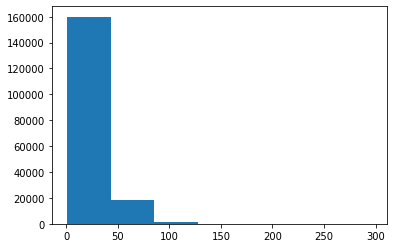

In [ ]:
# What's the distribution look like?
plt.hist(sent_lens, bins=7);

Looks like majority of our sentences are between 1 and 50 tokens in length. We can use numpy to find the value which covers `95%` of the sentence lengths. 

In [ ]:
output_seq = int(np.percentile(sent_lens,95))
output_seq

55

Wonderful! It looks like 95% of the sentences in our training set have a length of 55 tokens or less.

When we create our tokenization layer, we'll use this value to turn all of our sentences into the same length. Meaning sentences with a length below 55 get padded with zeros and sentences with a length above 55 get truncated (words after 55 get cut off).

## Create Text Vectorizer 

Now we've got a little more information about our texts, let's create a way to turn it into numbers.

To do so, we'll use the [`TextVectorization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/TextVectorization) layer from TensorFlow.

We'll keep all the parameters default except for `max_tokens` (the number of unique words in our dataset) and `output_sequence_length` (our desired output length for each vectorized sentence).

Section 3.2 of the [PubMed 200k RCT paper](https://arxiv.org/pdf/1710.06071.pdf) states the vocabulary size of the PubMed 20k dataset as 68,000. So we'll use that as our `max_tokens` parameter.

In [ ]:
# How many words are in our vocab? (Refer to table 2 of research paper)
max_tokens = 68000

In [ ]:
# Create text vectorizer
text_vectorizer = TextVectorization(max_tokens=max_tokens, # number of words in vocabulary
                                    output_sequence_length=55) # desired output length of vectorized sequences

# Adapt text vectorizer to training sentences (let it read the training data and figure out what number should represent what word)
text_vectorizer.adapt(train_sentences)

In [ ]:
# Test out text vectorizer
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")

Text:
the groups were well matched for demographics , disease severity , microbiology and appropriateness of the administered antimicrobials .

Length of text: 19

Vectorized text:
[[    2    24     9   221  1383    11  2349   114   332 22554     3  9240
      4     2   336  8764     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


Cool, we've now got a way to turn our sequences into numbers.

Using the [`get_vocabulary()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/TextVectorization) method of our `text_vectorizer` we can find out a few different tidbits about our text.

In [ ]:
# How many words in our training vocabulary?
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}"), 
print(f"Most common words in the vocabulary: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocabulary: {rct_20k_text_vocab[-5:]}")

Number of words in vocabulary: 64841
Most common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


## Create Embedding Layer 

Our `token_vectorization` layer maps the words in our text directly to numbers. However, this doesn't necessarily capture the relationships between those numbers.

To create a richer numerical representation of our text, we can use an **embedding**.

As our model learns (by going through many different examples of abstract sentences and their labels), it'll update its embedding to better represent the relationships between tokens in our corpus.

We can create a trainable embedding layer using TensorFlow's [`Embedding`](https://www.tensorflow.org/tutorials/text/word_embeddings) layer.

Once again, the main parameters we're concerned with here are the inputs and outputs of our `Embedding` layer.

In [ ]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab), # length of vocabulary
                               output_dim=128, # Note: different embedding sizes result in drastically different numbers of parameters to train
                               # Use masking to handle variable sequence lengths (save space)
                               mask_zero=True,
                               name="token_embedding") 

# Show example embedding
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
the groups were well matched for demographics , disease severity , microbiology and appropriateness of the administered antimicrobials .

Sentence after vectorization (before embedding):
[[    2    24     9   221  1383    11  2349   114   332 22554     3  9240
      4     2   336  8764     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
[[[ 0.04513817  0.00982295 -0.00829349 ... -0.00369787  0.01220313
   -0.02273264]
  [-0.01062187  0.02737396 -0.00880434 ...  0.02864267 -0.00317829
    0.02299947]
  [ 0.03486956  0.00229794 -0.02670623 ...  0.03544891 -0.01921269
    0.01156888]
  ...
  [-0.02255906  0.0392957   0.01859435 ...  0.04652112  0.03651471
    0.00437763]
  [-0.02255906  0.0392957   0.01859435 ...  0.04652112  0.03651471
    0.00

## Create datasets (as fast as possible)

We've gone through all the trouble of preprocessing our datasets to be used with a machine learning model, however, there are still a few steps we can use to make them work faster with our models.

Namely, the `tf.data` API provides methods which enable faster data loading.

The main steps we'll want to use with our data is to turn it into a `PrefetchDataset` of batches.

Doing so we'll ensure TensorFlow loads our data onto the GPU as fast as possible, in turn leading to faster training time.

To create a batched `PrefetchDataset` we can use the methods [`batch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch) and [`prefetch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch), the parameter [`tf.data.AUTOTUNE`](https://www.tensorflow.org/api_docs/python/tf/data#AUTOTUNE) will also allow TensorFlow to determine the optimal amount of compute to use to prepare datasets.

In [ ]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

## Model 1: Conv1D with token embeddings

Alright, we've now got a way to numerically represent our text and labels, time to build a series of deep models to try and improve upon our baseline.

All of our deep models will follow a similar structure:

```
Input (text) -> Tokenize -> Embedding -> Layers -> Output (label probability)
```

The main component we'll be changing throughout is the `Layers` component. The first model we're going to build is a 1-dimensional Convolutional Neural Network. 

In [ ]:
# Create 1D convolutional model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = token_embed(text_vectors) # create embedding
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile
model_1.compile(loss="categorical_crossentropy", # if your labels are integer form (not one hot) use sparse_categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

Wonderful! We've got our first deep sequence model built and ready to go. 

Checking out the model summary, you'll notice the majority of the trainable parameters are within the embedding layer. If we were to increase the size of the embedding (by increasing the `output_dim` parameter of the `Embedding` layer), the number of trainable parameters would increase dramatically.

It's time to fit our model to the training data but we're going to make a mindful change.

Since our training data contains nearly 200,000 sentences, fitting a deep model may take a while even with a GPU. So to keep our experiments swift, we're going to run them on a subset of the training dataset.

More specifically, we'll only use the first 10% of batches (about 18,000 samples) of the training set to train on and the first 10% of batches from the validation set to validate on.

In [ ]:
# Fit the model 
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset))   # only validate on 10% of the batches
                              )

Epoch 1/3
562/562 [==============================] - 62s 108ms/step - loss: 0.9168 - accuracy: 0.6422 - val_loss: 0.6858 - val_accuracy: 0.7384
Epoch 2/3
562/562 [==============================] - 60s 108ms/step - loss: 0.6574 - accuracy: 0.7555 - val_loss: 0.6332 - val_accuracy: 0.7666
Epoch 3/3
562/562 [==============================] - 59s 104ms/step - loss: 0.6167 - accuracy: 0.7732 - val_loss: 0.5955 - val_accuracy: 0.7799


In [ ]:
# Evaluate on whole validation dataset 
model_1.evaluate(valid_dataset)

945/945 [==============================] - 6s 6ms/step - loss: 0.5967 - accuracy: 0.7869


[0.5967037081718445, 0.7869058847427368]

In [ ]:
# Make prediction(our model predicts prediction probabilities for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs,model_1_pred_probs.shape

(array([[4.6281269e-01, 1.4865962e-01, 5.0541524e-02, 3.1286019e-01,
         2.5125856e-02],
        [4.3952897e-01, 2.8534845e-01, 1.5063397e-02, 2.5237641e-01,
         7.6828008e-03],
        [1.7155892e-01, 5.7917833e-03, 1.9904112e-03, 8.2062393e-01,
         3.4986144e-05],
        ...,
        [6.9889948e-06, 6.0035137e-04, 7.7335531e-04, 4.0162945e-06,
         9.9861526e-01],
        [5.4969203e-02, 4.7300449e-01, 8.6364262e-02, 5.9210259e-02,
         3.2645175e-01],
        [1.6046657e-01, 6.8338025e-01, 5.5939674e-02, 5.3542353e-02,
         4.6671201e-02]], dtype=float32), (30212, 5))

In [ ]:
# Convert pred probs to classes 
model_1_preds = tf.argmax(model_1_pred_probs,axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [ ]:
# Calculate model_1 results 
model_1_results = calculate_results(val_labels_label_encoded,model_1_preds)
model_1_results

{'accuracy': 0.7869058652191182,
 'f1': 0.7843718093078225,
 'precision': 0.7835572471192808,
 'recall': 0.7869058652191182}

## Model 2: Feature extraction with pretrained token embeddings

Training our own embeddings took a little while to run, slowing our experiments down.

Since we're moving towards replicating the model architecture in [*Neural Networks for Joint Sentence Classification
in Medical Paper Abstracts*](https://arxiv.org/pdf/1612.05251.pdf), it mentions they used a [pretrained GloVe embedding](https://nlp.stanford.edu/projects/glove/) as a way to initialise their token embeddings.

To emulate this, let's see what results we can get with the [pretrained Universal Sentence Encoder embeddings from TensorFlow Hub](https://tfhub.dev/google/universal-sentence-encoder/4).

The model structure will look like:

```
Inputs (string) -> Pretrained embeddings from TensorFlow Hub (Universal Sentence Encoder) -> Layers -> Output (prediction probabilities)
```

You'll notice the lack of tokenization layer we've used in a previous model. This is because the Universal Sentence Encoder (USE) takes care of tokenization for us.

To download the pretrained USE into a layer we can use in our model, we can use the [`hub.KerasLayer`](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer) class.

We'll keep the pretrained embeddings frozen (by setting `trainable=False`) and add a trainable couple of layers on the top to tailor the model outputs to our own data.


In [ ]:
# Download pretrained TensorFlow Hub USE
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                         trainable=False,
                         name="universal_sentence_encoder")

# Test out the embedding on a random sentence
random_training_sentence = random.choice(train_sentences)
print(f"Random training sentence:\n{random_training_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]} (truncated output)...\n")
print(f"Length of sentence embedding:\n{len(use_embedded_sentence[0])}")

Random training sentence:
an rct will be conducted at instituto de medicina integral prof fernando figueira ( imip ) , brazil .

Sentence after embedding:
[ 0.03416711  0.00668451 -0.05221562 -0.02082794  0.0330516   0.02676885
 -0.02369463 -0.01634613  0.069879   -0.00170117 -0.01636629 -0.07437813
  0.00034495  0.06879992 -0.03152782 -0.03977498 -0.00777454  0.08422009
 -0.0776634  -0.07738493 -0.01480117 -0.0566196  -0.01555172  0.06016202
  0.05116534 -0.01064298  0.03592043 -0.05058175 -0.05374717  0.00759505] (truncated output)...

Length of sentence embedding:
512


In [ ]:
# Define feature extractor model using TF Hub layer
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize text and create embedding
x = layers.Dense(128, activation="relu")(pretrained_embedding) # add a fully connected layer on top of the embedding
# Note: you could add more layers here if you wanted to
outputs = layers.Dense(5, activation="softmax")(x) # create the output layer
model_2 = tf.keras.Model(inputs=inputs,
                        outputs=outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Get a summary of the model
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


Checking the summary of our model we can see there's a large number of total parameters, however, the majority of these are non-trainable. This is because we set `training=False` when we instatiated our USE feature extractor layer.

So when we train our model, only the top two output layers will be trained.

In [ ]:
# Fit feature extractor model for 3 epochs
model_2.fit(train_dataset,
            steps_per_epoch=int(0.1 * len(train_dataset)),
            epochs=3,
            validation_data=valid_dataset,
            validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 10s 14ms/step - loss: 0.9180 - accuracy: 0.6501 - val_loss: 0.7995 - val_accuracy: 0.6898
Epoch 2/3
562/562 [==============================] - 7s 13ms/step - loss: 0.7706 - accuracy: 0.7018 - val_loss: 0.7570 - val_accuracy: 0.7051
Epoch 3/3
562/562 [==============================] - 7s 13ms/step - loss: 0.7546 - accuracy: 0.7111 - val_loss: 0.7428 - val_accuracy: 0.7124


In [ ]:
# Evaluate on whole validation dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 10s 11ms/step - loss: 0.7437 - accuracy: 0.7124


[0.7437105774879456, 0.7123659253120422]

In [ ]:
# Make predictions with feature extraction model
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

array([[4.0558574e-01, 3.8659757e-01, 3.1513346e-03, 1.9556889e-01,
        9.0964967e-03],
       [3.3814168e-01, 5.0668544e-01, 3.5202364e-03, 1.4847785e-01,
        3.1747050e-03],
       [2.1586949e-01, 1.4044425e-01, 1.6091740e-02, 5.8960944e-01,
        3.7985180e-02],
       ...,
       [2.3095687e-03, 6.4220554e-03, 5.8673602e-02, 9.1003452e-04,
        9.3168473e-01],
       [3.9733821e-03, 4.6605572e-02, 2.2374550e-01, 1.4550295e-03,
        7.2422045e-01],
       [1.7697443e-01, 3.0109346e-01, 4.5577058e-01, 5.4215738e-03,
        6.0740061e-02]], dtype=float32)

In [ ]:
# Convert the predictions with feature extraction model to classes
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [ ]:
# Calculate results from TF Hub pretrained embeddings results on validation set
model_2_results = calculate_results(y_true=val_labels_label_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 0.7123659473057063,
 'f1': 0.7094365456370941,
 'precision': 0.7125751937013398,
 'recall': 0.7123659473057063}

## Model 3: Conv1D with character embeddings

### Creating a character-level tokenizer

The [*Neural Networks for Joint Sentence Classification
in Medical Paper Abstracts*](https://arxiv.org/pdf/1612.05251.pdf) paper mentions their model uses a hybrid of token and character embeddings.

We've built models with a custom token embedding and a pretrained token embedding, we will now build one using a character embedding.
We can create a character-level embedding by first vectorizing our sequences (after they've been split into characters) using the [`TextVectorization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/TextVectorization) class and then passing those vectorized sequences through an [`Embedding`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) layer.

Before we can vectorize our sequences on a character-level we'll need to split them into characters. Let's write a function to do so.

In [ ]:
# Make function to split sentences into characters 
def split_chars(text):
  return " ".join(list(text))


# Text splitting non-character-level sequence into characters 
split_chars(target_sentence)

't h e   g r o u p s   w e r e   w e l l   m a t c h e d   f o r   d e m o g r a p h i c s   ,   d i s e a s e   s e v e r i t y   ,   m i c r o b i o l o g y   a n d   a p p r o p r i a t e n e s s   o f   t h e   a d m i n i s t e r e d   a n t i m i c r o b i a l s   .'

Great! Looks like our character-splitting function works. Let's create character-level datasets by splitting our sequence datasets into characters.

In [ ]:
# Split sequence level data splits into character level data splits 
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

To figure out how long our vectorized character sequences should be, let's check the distribution of our character sequence lengths.

In [ ]:
# What's the average character length? 
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_lens = np.mean(char_lens)
mean_char_lens

149.3662574983337

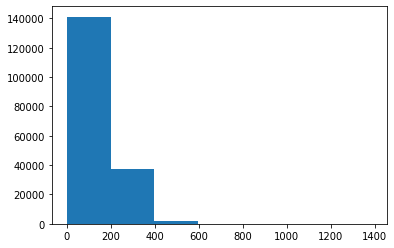

In [ ]:
# Check the distribution of our sequence  at a character level
plt.hist(char_lens,bins=7);

In [ ]:
# Finding what length of character value covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [ ]:
# Get all keyboard characters 
import string 
alphabet = string.ascii_lowercase + string.digits + string.punctuation 
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# Create char-level token vectorizer instance 
NUM_CHAR_TOKENS = len(alphabet)   # add  2 for space and OOV (OOV= out of vocab)
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length = output_seq_char_len,
                                    name = "char_vectorizer")  # set standardization to none if u want to include the punctuation 

# Adapt character vectorizer to training character 
char_vectorizer.adapt(train_chars)

In [ ]:
# Check character vocabulary characteristics
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


We can also test it on random sequences of characters to make sure it's working.

In [ ]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
t h e   n o n i n f e r i o r i t y   m a r g i n   w a s   s e t   a t   @   %   f o r   t h e   w o m a c   .

Length of chars: 45

Vectorized chars:
[[ 3 13  2  6  7  6  4  6 17  2  8  4  7  8  4  3 19 15  5  8 18  4  6 20
   5  9  9  2  3  5  3 17  7  8  3 13  2 20  7 15  5 11  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  

### Creating a character-level embedding
We've got a way to vectorize our character-level sequences, now's time to create a character-level embedding.

Just like our custom token embedding, we can do so using the [`tensorflow.keras.layers.Embedding`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) class.

Our character-level embedding layer requires an input dimension and output dimension. 

The input dimension (`input_dim`) will be equal to the number of different characters in our `char_vocab` (28). And since we're following the structure of the model in Figure 1 of [*Neural Networks for Joint Sentence Classification
in Medical Paper Abstracts*](https://arxiv.org/pdf/1612.05251.pdf), the output dimension of the character embedding (`output_dim`) will be 25.

In [ ]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS, # number of different characters
                              output_dim=25, # embedding dimension of each character (same as Figure 1 in https://arxiv.org/pdf/1612.05251.pdf)
                              mask_zero=False, # don't use masks (this messes up model_5 if set to True)
                              name="char_embed")

# Test out character embedding layer
print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
t h e   n o n i n f e r i o r i t y   m a r g i n   w a s   s e t   a t   @   %   f o r   t h e   w o m a c   .

Embedded chars (after vectorization and embedding):
[[[ 0.00217371 -0.02018966 -0.00545831 ... -0.0297277   0.03273103
   -0.00271611]
  [ 0.04947609  0.04915894  0.04111463 ... -0.03431976 -0.04996675
    0.04874194]
  [ 0.00090289 -0.0292045   0.04418502 ... -0.04380427 -0.02191787
   -0.00267734]
  ...
  [-0.01115495 -0.03192899  0.03458135 ... -0.01495631 -0.0054603
    0.02289008]
  [-0.01115495 -0.03192899  0.03458135 ... -0.01495631 -0.0054603
    0.02289008]
  [-0.01115495 -0.03192899  0.03458135 ... -0.01495631 -0.0054603
    0.02289008]]]

Character embedding shape: (1, 290, 25)


### Building a Conv1D model to fit on character embeddings
Now we've got a way to turn our character-level sequences into numbers (`char_vectorizer`) as well as numerically represent them as an embedding (`char_embed`) let's test how effective they are at encoding the information in our sequences by creating a character-level sequence model.

The model will have the same structure as our custom token embedding model (`model_1`) except it'll take character-level sequences as input instead of token-level sequences.

```
Input (character-level text) -> Tokenize -> Embedding -> Layers (Conv1D, GlobalMaxPool1D) -> Output (label probability)
```

In [ ]:
# Make Conv1D on chars only
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1D_char_embedding")

# Compile model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Check the summary of conv1d_char_model
model_3.summary()

Model: "model_3_conv1D_char_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           1700      
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_3 (Dense)             (None, 5

Before fitting our model on the data, we'll create char-level batched `PrefetchedDataset`'s.

In [ ]:
# Create char level dataset 
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars,train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars,val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars,test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

In [ ]:
# Fit the model on chars only 
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch = int(0.1*len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1*len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 17s 30ms/step - loss: 1.2644 - accuracy: 0.4901 - val_loss: 1.0353 - val_accuracy: 0.5898
Epoch 2/3
562/562 [==============================] - 16s 29ms/step - loss: 0.9986 - accuracy: 0.6023 - val_loss: 0.9307 - val_accuracy: 0.6310
Epoch 3/3
562/562 [==============================] - 16s 29ms/step - loss: 0.9146 - accuracy: 0.6446 - val_loss: 0.8641 - val_accuracy: 0.6622


In [ ]:
# Make predicitons with character model only 
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

array([[0.28126383, 0.4004962 , 0.06283595, 0.19697422, 0.05842973],
       [0.15657803, 0.38529602, 0.03536846, 0.3053549 , 0.1174026 ],
       [0.12524308, 0.1772285 , 0.13423307, 0.5032279 , 0.06006749],
       ...,
       [0.0230625 , 0.03890823, 0.08538543, 0.03043168, 0.82221216],
       [0.03602685, 0.1621283 , 0.25315973, 0.07385311, 0.474832  ],
       [0.37633556, 0.48363435, 0.05699552, 0.07528467, 0.00774988]],
      dtype=float32)

In [ ]:
# Convert prediction probabilities to classes
model_3_preds = tf.argmax(model_3_pred_probs,axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 4, 1])>

In [ ]:
# Calculate results for Conv1D model 
model_3_results = calculate_results(val_labels_label_encoded,model_3_preds)
model_3_results

{'accuracy': 0.6631470938699854,
 'f1': 0.6553300560141173,
 'precision': 0.6568662472801641,
 'recall': 0.6631470938699854}

## Model 4: Combining pretrained token embeddings + character embeddings (hybrid embedding layer)

In moving closer to build a model similar to the one in Figure 1 of [*Neural Networks for Joint Sentence Classification
in Medical Paper Abstracts*](https://arxiv.org/pdf/1612.05251.pdf), it's time we tackled the hybrid token embedding layer.

This hybrid token embedding layer is a combination of token embeddings and character embeddings. 

To start implementting the model in Figure 1, we're going to go through the following steps:
1. Create a token-level model (similar to `model_1`)
2. Create a character-level model (similar to `model_3`)
3. Combine (using [`layers.Concatenate`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Concatenate)) the outputs of 1 and 2
4. Build a series of output layers on top of 3 similar to Figure 1 and section 4.2 of [*Neural Networks for Joint Sentence Classification
in Medical Paper Abstracts*](https://arxiv.org/pdf/1612.05251.pdf)
5. Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output

In [ ]:
# 1. Setup token inputs/model 
token_inputs = layers.Input(shape=[],dtype=tf.string,name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128,activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,outputs=token_output)

# 2. Set up char inputs/model
char_inputs=layers.Input(shape=(1,),dtype=tf.string,name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)  # Bi-LSTM
char_model = tf.keras.Model(inputs=char_inputs,outputs=char_bi_lstm)

# 3. Combining 1 and 2 with `concatenate` (create a hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,char_model.output])

# 4. Create output layers - adding in Dropout layer, discussed in 4.2 section 
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128,activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer=layers.Dense(num_classes,activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs 
model_4 = tf.keras.Model(inputs=[token_model.input,char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

In [ ]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

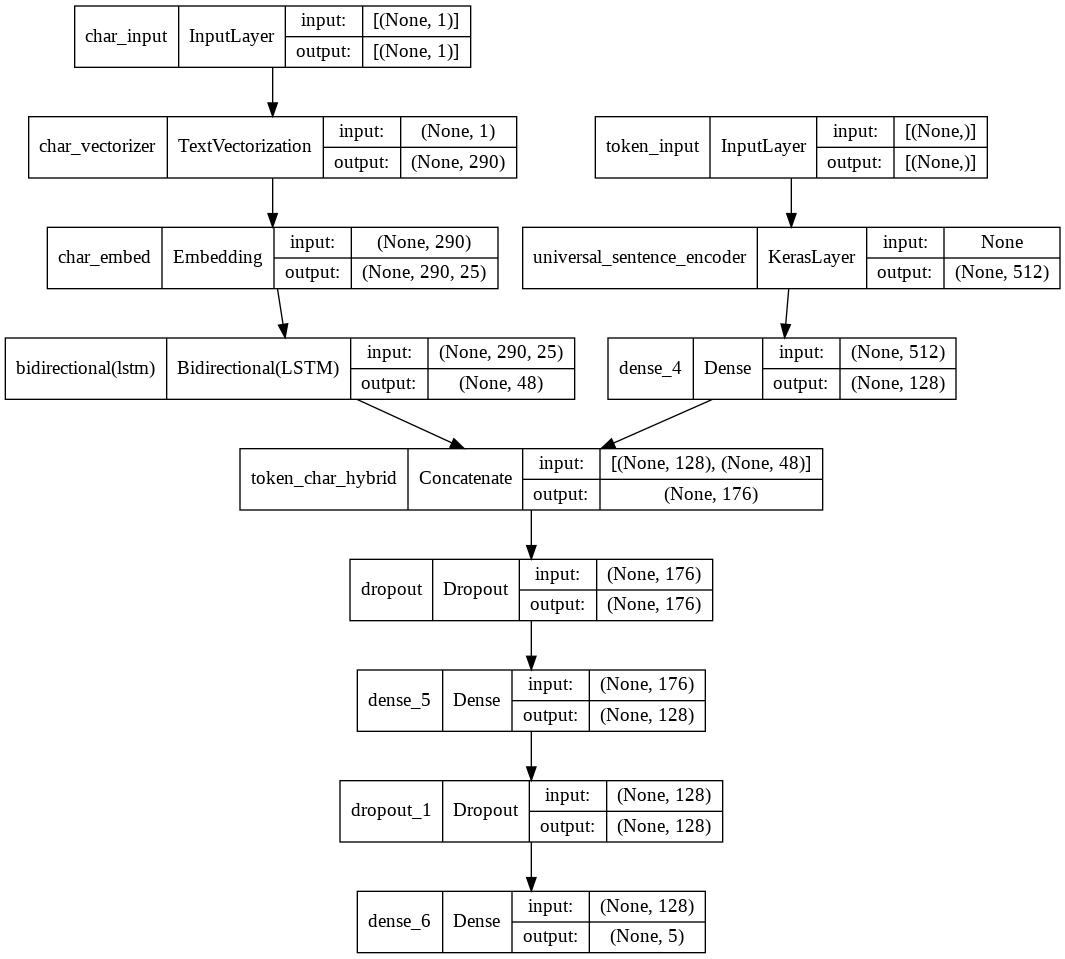

In [ ]:
# Plot hybrid token and character model 
tf.keras.utils.plot_model(model_4,show_shapes=True)

In [ ]:
# compile token char model 
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

And again, to keep our experiments fast, we'll fit our token-character-hybrid model on 10% of training and validate on 10% of validation batches. However, the difference with this model is that it requires two inputs, token-level sequences and character-level sequences.

We can do this by create a `tf.data.Dataset` with a tuple as it's first input, for example:
* `((token_data, char_data), (label))`

### Combining token and character data into a `tf.data` dataset

In [ ]:
# combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences,train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)  # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data,train_char_token_labels)) # combine data and labels 

# Prefetch and batch train data 
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# combine chars and tokens steps for our validation  dataset
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences,val_chars)) # make data
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)  # make labels
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data,val_char_token_labels)) # combine data and labels 
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# check out our training and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>)

### Fitting a model on token and character level sequences

In [ ]:
# Fit the model on tokens and chars 
history_model_4 = model_4.fit(train_char_token_dataset,
                              steps_per_epoch = int(0.1*len(train_char_token_dataset)),
                              epochs=3,
                              validation_data = val_char_token_dataset,
                              validation_steps = int(0.1*len(val_char_token_dataset))
                              )

Epoch 1/3
562/562 [==============================] - 128s 219ms/step - loss: 0.9852 - accuracy: 0.6048 - val_loss: 0.7947 - val_accuracy: 0.6938
Epoch 2/3
562/562 [==============================] - 131s 234ms/step - loss: 0.8030 - accuracy: 0.6898 - val_loss: 0.7235 - val_accuracy: 0.7264
Epoch 3/3
562/562 [==============================] - 129s 229ms/step - loss: 0.7790 - accuracy: 0.7064 - val_loss: 0.6946 - val_accuracy: 0.7394


In [ ]:
# Evaluate on the whole validation dataset 
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 78s 83ms/step - loss: 0.6980 - accuracy: 0.7336


[0.6980330944061279, 0.7335826754570007]

In [ ]:
# Make predictions using the token-character model 
model_4_pred_probs= model_4.predict(val_char_token_dataset)
model_4_pred_probs

array([[4.3083131e-01, 3.7463680e-01, 5.0217407e-03, 1.7815404e-01,
        1.1356149e-02],
       [3.4833401e-01, 5.0809962e-01, 3.5150216e-03, 1.3852334e-01,
        1.5281179e-03],
       [3.1889033e-01, 1.7472732e-01, 5.7758544e-02, 3.9887637e-01,
        4.9747363e-02],
       ...,
       [6.1349967e-04, 9.2245275e-03, 4.3111470e-02, 1.8694745e-04,
        9.4686353e-01],
       [6.1647319e-03, 4.5436561e-02, 1.8598844e-01, 2.5730955e-03,
        7.5983715e-01],
       [3.8527215e-01, 2.8959346e-01, 2.3252837e-01, 5.2554145e-02,
        4.0051896e-02]], dtype=float32)

In [ ]:
# Format pred probs into pred labels 
model_4_preds = tf.argmax(model_4_pred_probs,axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 0])>

In [ ]:
# get results 
model_4_results = calculate_results(val_labels_label_encoded,model_4_preds)
model_4_results

{'accuracy': 0.7335826823778631,
 'f1': 0.7308442565885918,
 'precision': 0.732757839455483,
 'recall': 0.7335826823778631}

## Model 5: Transfer Learning with pre trained token embedding+character embedding+position embedding 

We can see that test and character embedding models gave a boost to our model. Now, what if we tried to include enginnered features into the model, along with the token embedding and character embedding, called position embeddings. These embeddings might not be included in the training data, but they can be derived from our knowledge and ingested in a numerical way. 

In the function preprocessing_text_with_line_numbers, we created 2 new columns in the dataframe, `line_number` and `total_lines`. To use these engineered features, they must always be availible in runtime, which they are here. There might be other positional features as well, which could be included, but I have only included `line_number` and `total_lines` features. 

In [ ]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


### Create positional embeddings

Since our `"line_number"` and `"total_line"` columns are already numerical, we could pass them as they are to our model.

But to avoid our model thinking a line with `"line_number"=5` is five times greater than a line with `"line_number"=1`, we'll use one-hot-encoding to encode our `"line_number"` and `"total_lines"` features.

To do this, we can use the [`tf.one_hot`](https://www.tensorflow.org/api_docs/python/tf/one_hot) utility.

`tf.one_hot` returns a one-hot-encoded tensor. It accepts an array (or tensor) as input and the `depth` parameter determines the dimension of the returned tensor.

To figure out what we should set the `depth` parameter to, let's investigate the distribution of the `"line_number"` column.

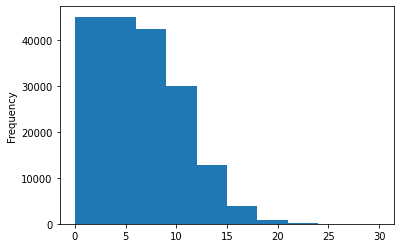

In [ ]:
# Check distribution of line_number column
train_df['line_number'].plot.hist();

In [ ]:
# Use tensorflow to create one hot encoded tensors of our "line_number" column
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(),depth=15)
val_line_numbers_one_hot =  tf.one_hot(val_df["line_number"].to_numpy(),depth=15)
test_line_numbers_one_hot =  tf.one_hot(test_df["line_number"].to_numpy(),depth=15)
train_line_numbers_one_hot[:10], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>, TensorShape([180040, 15]))

We can do the same as we've done for our `"line_number"` column with the `"total_lines"` column. First, let's find an appropriate value for the `depth` parameter of `tf.one_hot`.

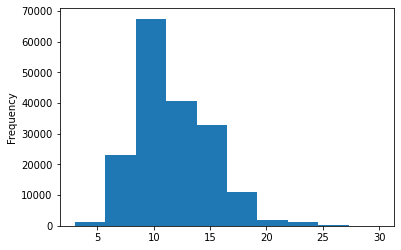

In [ ]:
# Check the distribution of total lines
train_df.total_lines.plot.hist();

In [ ]:
# Check the coverage of a "total_lines" value of 20
np.percentile(train_df.total_lines, 98) # a value of 20 covers 98% of samples

20.0

In [ ]:
# Use TensorFlow to create one-hot-encoded tensors of our "total_lines" column 
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

# Check shape and samples of total lines one-hot tensor
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]), <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.

### Building a tribrid embedding model

It's time to build a model which which incorporates token embeddings, character embeddings and our newly crafted positional embeddings.

More specifically we're going to go through the following steps:

1. Create a token-level model (similar to `model_1`)
2. Create a character-level model (similar to `model_3` with a slight modification to reflect the paper)
3. Create a `"line_number"` model (takes in one-hot-encoded `"line_number"` tensor and passes it through a non-linear layer)
4. Create a `"total_lines"` model (takes in one-hot-encoded `"total_lines"` tensor and passes it through a non-linear layer)
5. Combine (using [`layers.Concatenate`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Concatenate)) the outputs of 1 and 2 into a token-character-hybrid embedding and pass it series of output to Figure 1 and section 4.2 of [*Neural Networks for Joint Sentence Classification
in Medical Paper Abstracts*](https://arxiv.org/pdf/1612.05251.pdf)
6. Combine (using [`layers.Concatenate`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Concatenate)) the outputs of 3, 4 and 5 into a token-character-positional tribrid embedding 
7. Create an output layer to accept the tribrid embedding and output predicted label probabilities
8. Combine the inputs of 1, 2, 3, 4 and outputs of 7 into a [`tf.keras.Model`](https://www.tensorflow.org/api_docs/python/tf/keras/Model)


In [ ]:
# 1. Token Inputs 
token_inputs = layers.Input(shape=[],dtype="string",name="token_inputs")
token_embedding = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128,activation="relu")(token_embedding)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(1,),dtype="string",name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs = char_bi_lstm)

# 3. Line Numbers Model 
line_number_inputs = layers.Input(shape=(15,),dtype=tf.float32, name="line_number_input")
x = layers.Dense(32,activation="relu")(line_number_inputs)
line_number_model=tf.keras.Model(inputs=line_number_inputs,outputs=x)

# 4. Total Line model 
total_lines_inputs = layers.Input(shape=(20,),dtype=tf.float32,name="total_lines_input")
y = layers.Dense(32,activation="relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs=total_lines_inputs,
                                   outputs=y)

# 5. Combine Token and Char embeddings into a hybrid embedding 
combined_embeddings = layers.Concatenate(name="char_token_hybrid_embedding")([token_model.output,
                                                                              char_model.output])
z = layers.Dense(256,activation="relu")(combined_embeddings)
z=layers.Dropout(0.5)(z)         # Adding a dropout layer

# 6. Combine Positional Embeddings with 5
tribrid_embeddings = layers.Concatenate(name="char_token_positional_embedding")([line_number_model.output,
                                                                                 total_lines_model.output,
                                                                                 z])

# 7. Create output layer 
output_layer = layers.Dense(num_classes,activation="softmax",name="output_layer")(tribrid_embeddings)

# 8. Put everything together 
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_lines_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer,
                         name="tribrid_embedding_model")


In [ ]:
# Get a summary of our tribrid embedding model 
model_5.summary()

Model: "tribrid_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inp

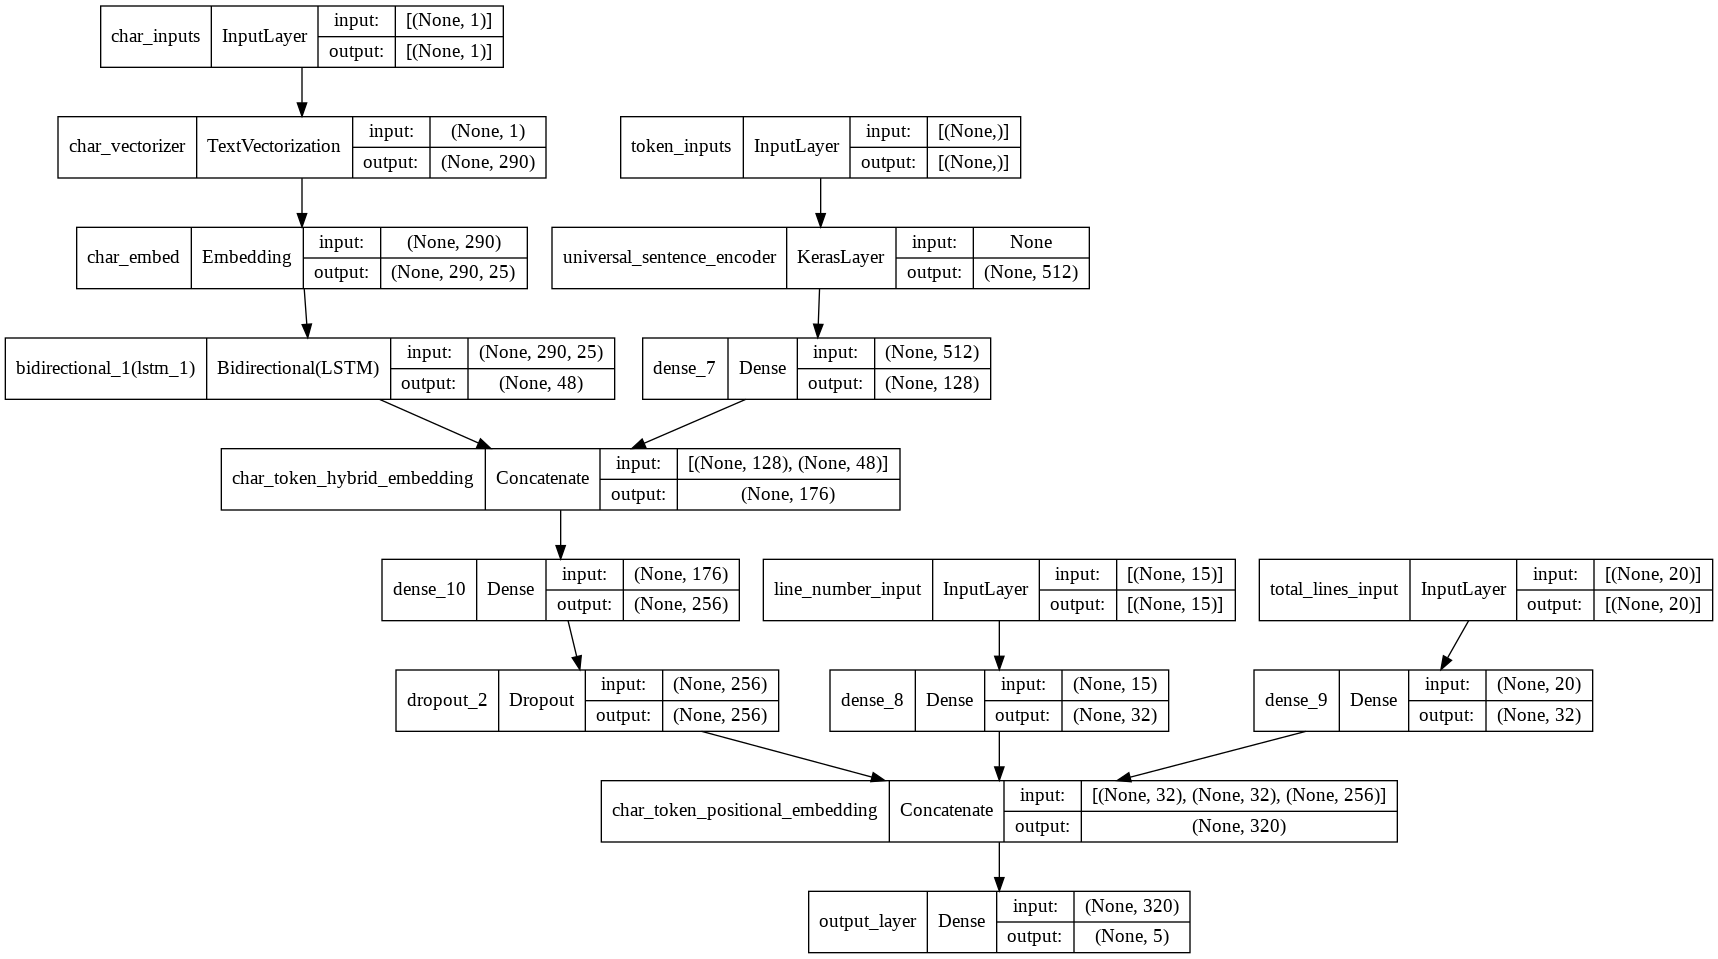

In [ ]:
# Plot model_5
tf.keras.utils.plot_model(model_5,show_shapes=True)

In [ ]:
# Compile token, char, positional embedding model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # add label smoothing (examples which are really confident get smoothed a little)
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

### Preparing tribrid datasets using tf.data

This time our model requires four feature inputs:
1. Train line numbers one-hot tensor (`train_line_numbers_one_hot`)
2. Train total lines one-hot tensor (`train_total_lines_one_hot`)
3. Token-level sequences tensor (`train_sentences`)
4. Char-level sequences tensor (`train_chars`)

We can pass these as tuples to our `tf.data.Dataset.from_tensor_slices()` method to create appropriately shaped and batched `PrefetchedDataset`'s.

In [ ]:
# Create training and validation datasets (all four kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, # line numbers
                                                                train_total_lines_one_hot, # total lines
                                                                train_sentences, # train tokens
                                                                train_chars)) # train chars
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset

(<PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>)

### Fitting, evaluating and making predictions with our tribrid model 

In [ ]:
# Fit the token, char and positional embedding model
history_model_5 = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=3,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 181s 308ms/step - loss: 1.0942 - accuracy: 0.7244 - val_loss: 0.9853 - val_accuracy: 0.8082
Epoch 2/3
562/562 [==============================] - 144s 256ms/step - loss: 0.9679 - accuracy: 0.8137 - val_loss: 0.9512 - val_accuracy: 0.8255
Epoch 3/3
562/562 [==============================] - 120s 213ms/step - loss: 0.9517 - accuracy: 0.8225 - val_loss: 0.9407 - val_accuracy: 0.8298


In [ ]:
# Make predictions with token-char-positional hybrid model
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset, verbose=1)
model_5_pred_probs

945/945 [==============================] - 55s 57ms/step


array([[0.48218283, 0.11870568, 0.01359148, 0.36836872, 0.01715129],
       [0.54119426, 0.10440921, 0.06043141, 0.28376466, 0.01020042],
       [0.3019491 , 0.11070181, 0.13370687, 0.37264937, 0.0809928 ],
       ...,
       [0.03613007, 0.09561191, 0.04223545, 0.02978213, 0.79624045],
       [0.03113434, 0.2444475 , 0.08462903, 0.02834891, 0.61144024],
       [0.20102529, 0.5913686 , 0.09988947, 0.04486496, 0.06285164]],
      dtype=float32)

In [ ]:
# Turn prediction probabilities into prediction classes
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [ ]:
# Calculate results of token-char-positional hybrid model
model_5_results = calculate_results(val_labels_label_encoded,model_5_preds)
model_5_results

{'accuracy': 0.8313915000661989,
 'f1': 0.8303275149086001,
 'precision': 0.830072425187766,
 'recall': 0.8313915000661989}

# Compare Model Results 

In [ ]:
# combine model results into a dataframe 
all_model_results = pd.DataFrame({"model_0_baseline":model_0_results,
                                  "model_1_custom_token":model_1_results,
                                  "model_2_pretrained_token_embedding":model_2_results,
                                  "model_3_custom_char_embedding":model_3_results,
                                  "model_4_hybrid_char_token_embedding":model_4_results,
                                  "model_5_pos_char_token_embedding":model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,0.721832,0.718647,0.721832,0.698925
model_1_custom_token,0.786906,0.783557,0.786906,0.784372
model_2_pretrained_token_embedding,0.712366,0.712575,0.712366,0.709437
model_3_custom_char_embedding,0.663147,0.656866,0.663147,0.655330
model_4_hybrid_char_token_embedding,0.733583,0.732758,0.733583,0.730844
model_5_pos_char_token_embedding,0.831392,0.830072,0.831392,0.830328


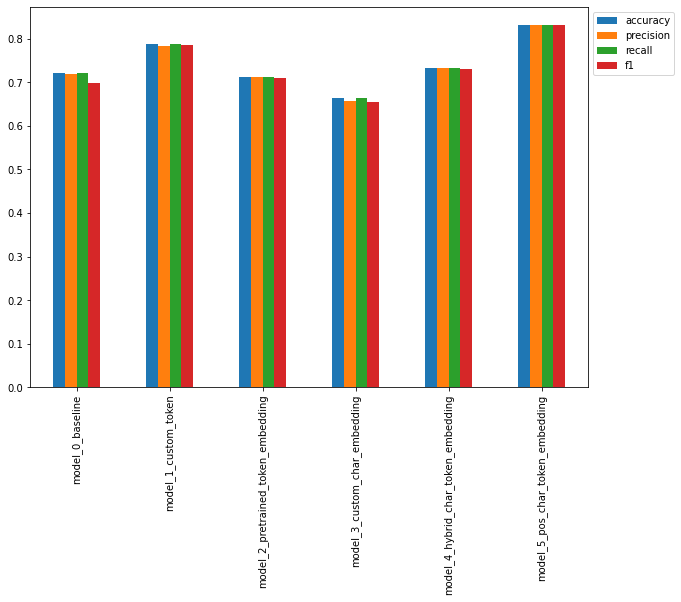

In [ ]:
# Plot and compare all model results 
all_model_results.plot(kind="bar",figsize=(10,7)).legend(bbox_to_anchor=(1.0,1.0));

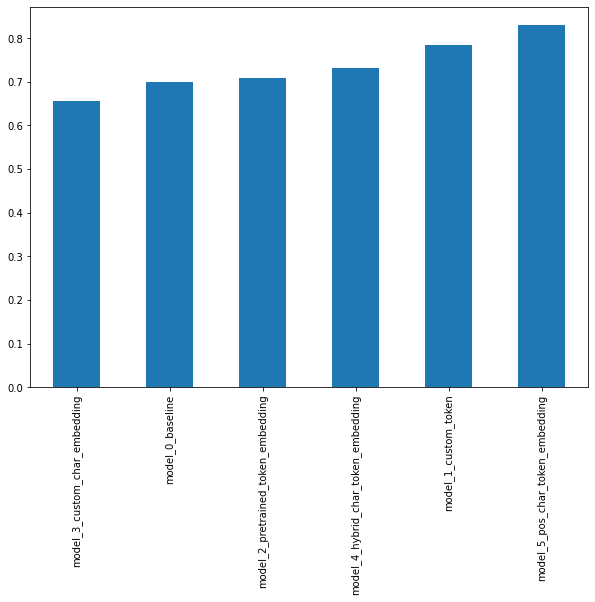

In [ ]:
# Sort the models results by f1 scores 
all_model_results.sort_values(by="f1",ascending=True)["f1"].plot(kind="bar",figsize=(10,7));

Based on F1-scores, it looks like our tribrid embedding model performs the best by a fair margin.

Though, in comparison to the results reported in Table 3 of the [*PubMed 200k RCT:
a Dataset for Sequential Sentence Classification in Medical Abstracts*](https://arxiv.org/pdf/1710.06071.pdf) paper, our model's F1-score is still underperforming (the authors model achieves an F1-score of 90.0 on the 20k RCT dataset versus our F1-score of ~82.6).

There are some things to note about this difference:
* Our models (with an exception for the baseline) have been trained on ~18,000 (10% of batches) samples of sequences and labels rather than the full ~180,000 in the 20k RCT dataset.
* Our model's prediction performance levels have been evaluated on the validation dataset not the test dataset (we'll evaluate our best model on the test dataset shortly).

## Save and load best performing model

Since we've been through a fair few experiments, it's a good idea to save our best performing model so we can reuse it without having to retrain it.

In [ ]:
# Save best performing model to SavedModel format (default)
model_5.save("skimlit_tribrid_model") # model will be saved to path specified by string

INFO:tensorflow:Assets written to: skimlit_tribrid_model/assets


INFO:tensorflow:Assets written to: skimlit_tribrid_model/assets


## Download the model 

In [ ]:
# Download pretrained model from Google Storage
!mkdir -p saved_model
model_5.save('saved_model/kimlit_tribrid_model') 

INFO:tensorflow:Assets written to: saved_model/kimlit_tribrid_model/assets


INFO:tensorflow:Assets written to: saved_model/kimlit_tribrid_model/assets


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub 
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

model_path = "/content/saved_model/kimlit_tribrid_model"

# Load downloaded model from Google Storage
loaded_model = tf.keras.models.load_model(model_path,
                                          custom_objects = {
                                              "TextVectorization": TextVectorization,
                                              "KerasLayer": hub.KerasLayer
                                          })#,
                                          # Note: with TensorFlow 2.5+ if your SavedModel has a keras_metadata.pb file 
                                          # (created when using model.save()), you shouldn't need the custom_objects
                                          # parameter. I'm leaving the code below here in case you do.
                                          # custom_objects={"TextVectorization": TextVectorization, # required for char vectorization
                                          #                 "KerasLayer": hub.KerasLayer}) # required for token embedding

In [ ]:
# Make predictions with the loaded model on the validation set
loaded_pred_probs = loaded_model.predict(val_pos_char_token_dataset, verbose=1)
loaded_preds = tf.argmax(loaded_pred_probs, axis=1)
loaded_preds[:10]

945/945 [==============================] - 80s 83ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1])>

In [ ]:
# Evaluate loaded model's predictions
loaded_model_results = calculate_results(val_labels_label_encoded,
                                         loaded_preds)
loaded_model_results

{'accuracy': 0.8310605057593009,
 'f1': 0.8297704285170588,
 'precision': 0.8293032694502942,
 'recall': 0.8310605057593009}

In [ ]:
# Check loaded model summary (note the number of trainable parameters)
loaded_model.summary()

Model: "tribrid_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, None)        0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inp

# Evaluate model on test dataset


In [ ]:
# Create test dataset batch and prefetched
test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                               test_total_lines_one_hot,
                                                               test_sentences,
                                                               test_chars))
test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data, test_pos_char_token_labels))
test_pos_char_token_dataset = test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Check shapes
test_pos_char_token_dataset

<PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>

In [ ]:
# Make predictions on the test dataset
test_pred_probs = loaded_model.predict(test_pos_char_token_dataset,
                                       verbose=1)
test_preds = tf.argmax(test_pred_probs, axis=1)
test_preds[:10]

942/942 [==============================] - 60s 64ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([3, 3, 2, 2, 4, 4, 4, 1, 4, 0])>

In [ ]:
# Evaluate loaded model test predictions
loaded_model_test_results = calculate_results(y_true=test_labels_label_encoded,
                                              y_pred=test_preds)
loaded_model_test_results

{'accuracy': 0.8268790443006471,
 'f1': 0.8255779389010075,
 'precision': 0.8250353592463737,
 'recall': 0.8268790443006471}

It seems our best model (so far) still has some ways to go to match the performance of the results in the paper (their model gets 90.0 F1-score on the test dataset, where as ours gets ~82.1 F1-score).

However, as we discussed before our model has only been trained on 20,000 out of the total ~180,000 sequences in the RCT 20k dataset.
